In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Total # of outliers: 2061


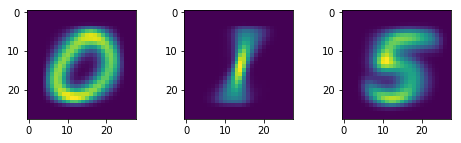

In [2]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test  = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255

idx_train = (y_train == 0) |(y_train == 1) | (y_train == 5) | (np.random.rand(y_train.shape[0]) < 0.05)
x_train = x_train[idx_train,:]
y_train = y_train[idx_train]

y_train[(y_train != 0) & (y_train != 1) & (y_train != 5)] = 11
y_train[y_train == 0] = 0
y_train[y_train == 1] = 1
y_train[y_train == 5] = 2
y_train[y_train > 3] = 3

mean_train = np.zeros((3,original_dim))
mean_train[0,:] = np.mean(x_train[y_train == 0,:], axis = 0)
mean_train[1,:] = np.mean(x_train[y_train == 1,:], axis = 0)
mean_train[2,:] = np.mean(x_train[y_train == 2,:], axis = 0)

fig = plt.figure(figsize=(8,2)) 
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.imshow(np.reshape(mean_train[i,:],[28,28]))
plt.figure("Mean Image of Each Digit")
print('Total # of outliers:', sum(y_train == 3))

In [3]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 384
intermediate_dim_2 = 64
batch_size = 256
latent_dim = 4
cat_dim = 1
class_num = 3
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
inter_x1 = Dense(intermediate_dim, activation='relu', name='encoder_intermediate')(inputs)
inter_x2 = Dense(intermediate_dim_2, activation='relu', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_2, activation='relu', name='encoder_intermediate_3')(inter_x1)

# add 3 means as additional parameters
dummy = Input(shape=(1,), name='dummy')
mu_vector = Dense(class_num*latent_dim, name='mu_vector',use_bias=False)(dummy)
mu = Reshape((class_num,latent_dim), name='mu')(mu_vector)

# prior categorical distribution
pi = Dense(class_num, activation='softmax', name='pi')(dummy)

# posterior categorical distribution
c = Dense(class_num, activation='softmax', name='c')(inter_x2)

# outlier/non-outlier classification (Posterior Beta)
# inter_outlier = Dense(128, activation='relu', name='inter_outlier')(x)
c_outlier = Dense(2, activation='softmax', name='c_outlier')(inter_x3)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x2)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x2)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs,dummy], [z_mean, z_log_var, z, mu, c, c_outlier, pi], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim_2, activation='relu')(latent_inputs)
inter_y2 = Dense(intermediate_dim, activation='relu')(inter_y1)
outputs = Dense(original_dim, activation='sigmoid')(inter_y2)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder([inputs,dummy])[2])
vae = Model([inputs,dummy], outputs, name='vae_mlp')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
encoder_intermediate (Dense)    (None, 384)          301440      encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_intermediate_2 (Dense)  (None, 64)           24640       encoder_intermediate[0][0]       
__________________________________________________________________________________________________
dummy (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
z_mean (De

In [4]:
models = (encoder, decoder)
dummy_train = np.ones((x_train.shape[0],1))

# weight for outlier Beta prior
# portion of outlier class
Lambda1 = 1
Lambda2 = 200 
Alpha = 0.05

# reconstruction loss
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss = K.tf.multiply(reconstruction_loss, c_outlier[:,0])
reconstruction_loss *= original_dim

# sum over reconstruction loss and kl-div loss
kl_loss_all = K.tf.get_variable("kl_loss_all", [batch_size,1], 
                                dtype=K.tf.float32,initializer=K.tf.zeros_initializer)
kl_cat_all = K.tf.get_variable("kl_cat_all", [batch_size,1], 
                                dtype=K.tf.float32,initializer=K.tf.zeros_initializer)
dir_prior_all = K.tf.get_variable("dir_prior_all", [batch_size,1], 
                                  dtype=K.tf.float32,initializer=K.tf.zeros_initializer)

for i in range(0,class_num):
    # stick-breaking reconstruction of categorical distribution
    c_inlier = K.tf.multiply(c[:,i],c_outlier[:,0])
    
    # kl-divergence between q(z|x) and p(z|c)
    kl_loss = 1 + z_log_var - K.square(z_mean-mu[:,i,:]) - K.exp(z_log_var)
    kl_loss = K.tf.multiply(K.sum(kl_loss, axis=-1), c_inlier)
    kl_loss *= -0.5
    kl_loss_all += kl_loss
    
    # kl-divergence between q(c|x) and p(c) (not including outlier class)
    mc = K.mean(c[:,i])
    mpi = K.mean(pi[:,i])
    kl_cat = mc * K.log(mc)- mc * K.log(mpi)
    kl_cat_all += kl_cat
    
    # Dir prior: Dir(3, 3, ..., 3)
    dir_prior = -0.1*K.log(pi[:,i])
    dir_prior_all += dir_prior
    
# kl-divergence between Beta prior and Beta posterior (outlier class)
mco1 = K.mean(c_outlier[:,0])
mco2 = K.mean(c_outlier[:,1])
mpo1 = 1-Alpha
mpo2 = Alpha
kl_cat_outlier = (mco1 * K.log(mco1)- mco1 * np.log(mpo1)+
                  mco2 * K.log(mco2)- mco2 * np.log(mpo2))
#kl_cat_outlier = K.square(mco2)

# total loss
vae_loss = K.mean(reconstruction_loss+
                  kl_loss_all+
                  dir_prior_all+
                  Lambda1*kl_cat_all)+Lambda2*kl_cat_outlier

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

#vae.load_weights('vae_mlp_mnist.h5')
vae.fit([x_train,dummy_train],
        epochs=epochs,
        batch_size=batch_size)
vae.save_weights('vae_mlp_mnist_updated.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dummy (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 351583      encoder_input[0][0]              
                                                                 dummy[0][0]                      
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          327120      encoder[1][2]                    
Total para

In [5]:
[z_mean, z_log_var, z, mu, c, c_outlier, pi] = encoder.predict([x_train,dummy_train],batch_size=batch_size)

# estimate label
labels = np.zeros(x_train.shape[0])
for i in range(0, x_train.shape[0]):
    max_prob = np.max(np.multiply(c[i,:],c_outlier[i,0]))
    idx = np.argmax(np.multiply(c[i,:],c_outlier[i,0]))
    if (max_prob > c_outlier[i,1]):
        labels[i] = idx
    else:
        labels[i] = class_num

Text(0.5,1,'Mean Image of Each Estimated Cluster')

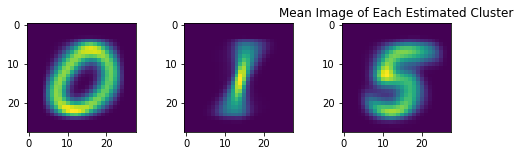

In [6]:
dist = np.zeros(3)
labels_new = np.zeros((x_train.shape[0],)) + 3

# matched estimated cluster with ground-truth cluster
for i in range(0,3):
    mean_est = np.mean(x_train[labels == i,:], axis = 0)
    for j in range(0,3):
       dist[j] = np.linalg.norm(mean_train[j,:]-mean_est)
    
    idx_shuffle = np.argmin(dist)
    labels_new[labels == i] = idx_shuffle

fig = plt.figure(figsize=(8,2))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.imshow(np.reshape(np.mean(x_train[labels_new == i,:],axis=0),[28,28]))
plt.title("Mean Image of Each Estimated Cluster")

In [12]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(z_mean)

Text(0.5,1,'Latent Space Representation Estimated by tGM-VAE')

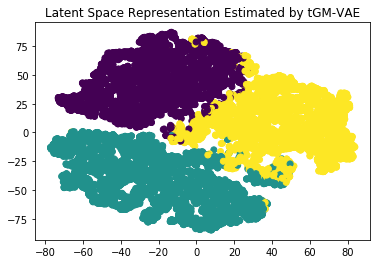

In [25]:
idx = labels_new < 3
plt.scatter(X_embedded[idx,0],X_embedded[idx,1],c=labels_new[idx])
plt.title('Latent Space Representation Estimated by tGM-VAE')